In [1]:
import glob
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import yaml


In [2]:
def fmt(x):
    return -1*int(x)

In [3]:
def plot_bathymetry(ax, etopo, levels=[-1000], colors='grey', alpha=1):
    lons = etopo.x.values
    lats = etopo.y.values
    lons, lats = np.meshgrid(lons,lats)
    bathy = etopo.z.values
    CS = ax.contour(lons,lats,bathy,levels, transform=ccrs.PlateCarree(),
                    linestyles='solid',colors=colors,alpha=alpha,linewidths=0.5, )
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=8)

In [4]:
lat_min = 45
lat_max = 56
lon_min = -60
lon_max = -42.5


In [5]:
etopo = '/home/soontiensn/data/ocn-nav/ETOPO1_Bed_g_gmt4.grd'
detopo = xr.open_dataset(etopo)
esel = detopo.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))

In [6]:
drifterID_file = 'NLDrifterIDs.yaml'
with open(drifterID_file) as f:
    deployments = yaml.safe_load(f)

In [7]:
deployments.keys()

dict_keys(['LaurentionChannel', 'NLRegion2021', 'Arctic2022', 'NLSpringAZMP2022', 'NLFallAZMP2022', 'NLSpringAZMP2023', 'NLSummerAZMP2023', 'StudentsonIce2023', 'NLFallAZMP2023', 'NLSummerAZMP2024', 'StudentsonIce2024'])

In [8]:
ds = ['NLSummerAZMP2024',  'StudentsonIce2024']
data_dir = 'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311' 

In [9]:
def gather_data(ID):
    """Open xarray dataset for files associated with a drifter ID"""
    files = glob.glob(os.path.join(data_dir, 'monthly', '*', f'*{ID}*.nc'))
    if not files:
        files = glob.glob(os.path.join(data_dir, 'latest', '*', f'*{ID}*.nc'))
    if not files:
        print(f'No files found for ID {ID}')
        return None
    d = xr.open_mfdataset(files)
    return d

In [10]:
def plot_dataset_timeseries(d, ax, var='TEMP'):
    """Plot var timeseries for a dataset"""
    if var == 'TEMP':
        dind = 1
    if var == 'EWCT' or var == 'NSCT':
        dind = 2
    if var == 'WSPE_MODEL' or var == 'WSPN_MODEL':
        dind = 0
    dqc = d.where(d[f'{var}_QC']==1)
    data = dqc[var].isel(DEPTH=dind).values
    ax.plot(dqc.TIME, data)
    ax.set_ylabel(f'{d[var].long_name}\n[{d[var].units}]')

In [11]:
def plot_map(d,ax,vmin=4, vmax=16):
    mesh = ax.scatter(d.LONGITUDE.values, d.LATITUDE.values, c=d.sel(DEPTH=1).TEMP.values,
                      vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),s=1)
    ax.plot(d.LONGITUDE.values[0], d.LATITUDE.values[0], '*C3', markeredgecolor='k',markersize=10)
    return mesh

No files found for ID 3801759
No files found for ID 6801975
No files found for ID 2802157
No files found for ID 2802158
No files found for ID 7811001
No files found for ID 2802159


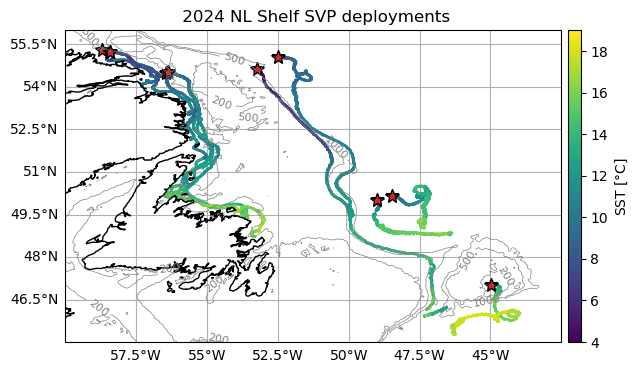

In [12]:
fig, ax=plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()},
                    )
for dep in ds:
    IDs = deployments[dep]
    for ID in IDs:
        d = gather_data(ID)
        if not d:
            continue
        mesh = plot_map(d,ax,vmin=4,vmax=19)
plot_bathymetry(ax, esel, levels=[-1000, -500, -200])
ax.coastlines()
ax.gridlines(draw_labels=['bottom', 'left'],zorder=0)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_title(' 2024 NL Shelf SVP deployments')
cax = fig.add_axes([ax.get_position().x1+0.01,
                    ax.get_position().y0,
                    0.02,
                    ax.get_position().height])

cbar = plt.colorbar(mesh,cax=cax)
cbar.set_label(r'SST [$\degree$C]')

In [13]:
fig.savefig('SVPNLShelf2024.png', dpi=300, bbox_inches='tight')